<a href="https://colab.research.google.com/github/Flychuban/Fat_Percentage_Prediction/blob/main/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [62]:
df = pd.read_csv('/content/drive/MyDrive/BodyFatPrediction/bodyfat.csv')
df.head(10)

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
5,1.0502,20.9,24,210.25,74.75,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8
6,1.0549,19.2,26,181.00,69.75,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7
7,1.0704,12.4,25,176.00,72.50,37.8,99.6,88.5,97.1,60.0,39.4,23.2,30.5,29.0,18.8
8,1.0900,4.1,25,191.00,74.00,38.1,100.9,82.5,99.9,62.9,38.3,23.8,35.9,31.1,18.2
9,1.0722,11.7,23,198.25,73.50,42.1,99.6,88.6,104.1,63.1,41.7,25.0,35.6,30.0,19.2


Transform lbb to kg
          inch to cm
Drop Density because of the high negative correlation with Body Fat.
Run just once for right corrections

In [63]:
df['Weight'] = [x * 0.453 for x in df['Weight']]
df['Height'] = [x * 2.54 for x in df['Height']]
df.drop(columns=['Density'], axis=0, inplace=True)

In [64]:
df.head(10)

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,69.87525,172.085,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,78.48225,183.515,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,69.76200,168.275,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,83.69175,183.515,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,83.46525,180.975,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
5,20.9,24,95.24325,189.865,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8
6,19.2,26,81.99300,177.165,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7
7,12.4,25,79.72800,184.150,37.8,99.6,88.5,97.1,60.0,39.4,23.2,30.5,29.0,18.8
8,4.1,25,86.52300,187.960,38.1,100.9,82.5,99.9,62.9,38.3,23.8,35.9,31.1,18.2
9,11.7,23,89.80725,186.690,42.1,99.6,88.6,104.1,63.1,41.7,25.0,35.6,30.0,19.2


Data analysis

In [65]:
# All valuse are not NULL
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  252 non-null    float64
 1   Age      252 non-null    int64  
 2   Weight   252 non-null    float64
 3   Height   252 non-null    float64
 4   Neck     252 non-null    float64
 5   Chest    252 non-null    float64
 6   Abdomen  252 non-null    float64
 7   Hip      252 non-null    float64
 8   Thigh    252 non-null    float64
 9   Knee     252 non-null    float64
 10  Ankle    252 non-null    float64
 11  Biceps   252 non-null    float64
 12  Forearm  252 non-null    float64
 13  Wrist    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


In [66]:
df.describe()

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,19.150794,44.884921,81.052755,178.177976,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,8.368740,12.602040,13.313289,9.303654,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.000000,22.000000,53.680500,74.930000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,12.475000,35.750000,72.027000,173.355000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,19.200000,43.000000,79.954500,177.800000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,25.300000,54.000000,89.241000,183.515000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,47.500000,81.000000,164.506950,197.485000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


<Axes: >

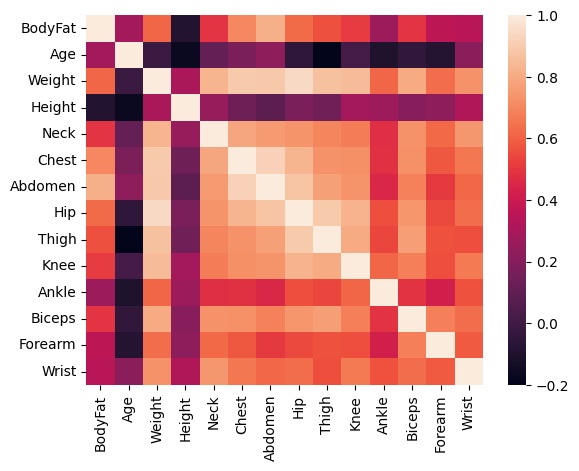

In [67]:
# We can see that there aren't very strong correlations which is good
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [68]:
df

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,69.87525,172.085,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,78.48225,183.515,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,69.76200,168.275,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,83.69175,183.515,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,83.46525,180.975,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,11.0,70,60.81525,170.180,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5
248,33.6,72,91.05300,177.165,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1
249,29.3,72,84.59775,167.640,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0
250,26.0,72,86.40975,179.070,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8


Get all features and labels

In [72]:
y = df['BodyFat']
X = df.drop(columns=['BodyFat'], axis=0, inplace=False)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, shuffle=True)

Data should be scaled (MinMax or Standard )